In [27]:
from qiskit import QuantumCircuit, QuantumRegister
from qiskit import transpile 
from qiskit_aer import Aer
import numpy as np

# Para una compuerta doblemente controlada
Se realizan rotaciones controladas con compuertas Hadamard y P

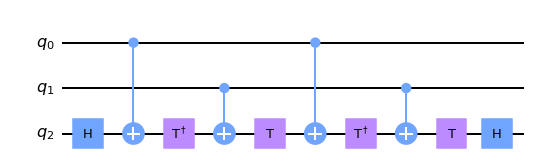

In [225]:
qc = QuantumCircuit(3)
qc.h(2)
qc.cx(0,2)
qc.tdg(2)
qc.cx(1,2)
qc.t(2)
qc.cx(0,2)
qc.tdg(2)
qc.cx(1,2)
qc.t(2)
qc.h(2)
qc.draw('mpl')

Empleando solamente la compuerta U se emplean los siguientes ángulos:
para obtener el mismo resultado de la Hadamard se emplea (pi/2,0,pi)
para obtener el mismo resultado de la la $T$ se emplea (0,0,pi/4) y la $T\dagger$

In [221]:
def toffoli() -> QuantumCircuit:
    qr = QuantumRegister(3, "q")
    qc = QuantumCircuit(qr)
    qc.u(np.pi/2, 0, np.pi, qr[2])# H
    qc.cx(qr[0],qr[2])# CX
    qc.u(0, 0, -np.pi/4, qr[2])# T-1
    qc.cx(qr[1],qr[2])# CX
    qc.u(0, 0, np.pi/4, qr[2])# T
    qc.cx(qr[0],qr[2])# H
    qc.u(0, 0, -np.pi/4, qr[2])# T-1
    qc.cx(qr[1],qr[2])# CX
    qc.u(0, 0, np.pi/4, qr[2])# T
    qc.u(np.pi/2, 0, np.pi, qr[2])# H
    return qc


Probando la descomposición de la compuerta

In [222]:
arreglo = ['000','001','010','011','100','101','110','111']

for dato in arreglo:
    qr = QuantumRegister(3, "q")
    qc = QuantumCircuit(qr)
    cont = 0
    for i in reversed(dato):
        if i == '1':
            qc.x(qr[cont])
        cont += 1

    qc.append(toffoli(), [qr[2],qr[1],qr[0]])

    backend = Aer.get_backend('statevector_simulator')
    compilado = transpile(qc, backend)
    job = backend.run(compilado, shots=1024) 
    result = job.result()
    counts = result.get_counts()
    
    print(dato,"-",counts)

000 - {'000': 1.000000000000001}
001 - {'001': 1.0}
010 - {'010': 1.000000000000001}
011 - {'011': 1.0}
100 - {'100': 1.000000000000001}
101 - {'101': 1.0}
110 - {'111': 1.0}
111 - {'110': 1.000000000000001}


## Compuerta multicontrolada
Generalizando es uso de la compuerta anterior, se aplican las misma rotaciones en una función recursiva

In [ ]:
def rotaciones(numControl,total):
    qr = QuantumRegister(total+1, "q")
    qc = QuantumCircuit(qr)
    
    qc.u(0, 0, -np.pi/4, qr[total]) #T-1
    qc.cx(qr[numControl], qr[total]) #CX
    qc.u(0, 0, np.pi/4, qr[total]) #T #T-1
    
    return qc.to_instruction()

def Haddamard(total):
    qr = QuantumRegister(total+1, "q")
    qc = QuantumCircuit(qr)
    
    qc.u(np.pi/2, 0, np.pi, qr[total]) #H
    
    return qc.to_instruction()


def multiControlGeneral(numControl,total) -> QuantumCircuit:
    qr = QuantumRegister(total+1, "q")
    qc = QuantumCircuit(qr)
        
    qubitControl = []
    for j in range(total+1):
        qubitControl.append(qr[j])

    if numControl == 1:
        qc.cx(qr[0],qr[total])#t,C
    else:        
        numControl -= 1

        qc.append(Haddamard(total),qubitControl)
        
        qc.append(multiControlGeneral(numControl,total),qubitControl)
        qc.append(rotaciones(numControl,total),qubitControl)        
        qc.append(multiControlGeneral(numControl,total),qubitControl)
        qc.append(rotaciones(numControl,total),qubitControl)
        
        qc.append(Haddamard(total),qubitControl)
        
    return qc.to_instruction()

Probando con diferentes arreglos para el uso en multiples controles

In [223]:
# arreglo = ['00','01','10','11']
# arreglo = ['000','001','010','011','100','101','110','111']
# arreglo = ['0000','0001','0010','0011','0100','0101','0110','0111',
#            '1000','1001','1010','1011','1100','1101','1110','1111']
arreglo = ['00000','00001','00010','00011','00100','00101','00110','00111',
           '01000','01001','01010','01011','01100','01101','01110','01111',
           '10000','10001','10010','10011','10100','10101','10110','10111',
           '11000','11001','11010','11011','11100','11101','11110','11111']

for dato in arreglo:
    numControl = 4
    qr = QuantumRegister(numControl+1, "q")
    qc = QuantumCircuit(qr)
    cont = 0
    for i in reversed(dato):
        if i == '1':
            qc.x(qr[cont])
        cont += 1
    
    qubitControl = []
    for j in range(numControl,-1,-1):
        qubitControl.append(qr[j])

    qc.append(multiControlGeneral(numControl,numControl), qubitControl)

    backend = Aer.get_backend('statevector_simulator')
    compilado = transpile(qc, backend)
    job = backend.run(compilado, shots=1024) 
    result = job.result()
    counts = result.get_counts()
    
    print(dato,"-",counts)


00000 - {'00000': 1.000000000000004}
00001 - {'00001': 1.000000000000003}
00010 - {'00010': 1.000000000000004}
00011 - {'00011': 1.000000000000003}
00100 - {'00100': 1.000000000000004}
00101 - {'00101': 1.000000000000003}
00110 - {'00110': 1.000000000000003}
00111 - {'00111': 1.000000000000003}
01000 - {'01000': 1.000000000000003}
01001 - {'01001': 1.000000000000003}
01010 - {'01010': 1.000000000000004}
01011 - {'01011': 1.000000000000003}
01100 - {'01100': 1.000000000000004}
01101 - {'01101': 1.000000000000003}
01110 - {'01110': 1.000000000000003}
01111 - {'01111': 1.000000000000003}
10000 - {'10000': 1.000000000000003}
10001 - {'10001': 1.000000000000003}
10010 - {'10010': 1.000000000000004}
10011 - {'10011': 1.000000000000003}
10100 - {'10100': 1.000000000000004}
10101 - {'10101': 1.000000000000003}
10110 - {'10110': 1.000000000000003}
10111 - {'10111': 1.000000000000003}
11000 - {'11000': 1.000000000000004}
11001 - {'11001': 1.000000000000003}
11010 - {'11010': 1.000000000000003}
1